In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.6 MB/s eta 0:00:00


In [2]:
!pip install shapely

In [3]:
# Import libraries penting

# Untuk manipulasi dan visualisasi data
import os
import cv2
import json
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import filters
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Untuk deep learning
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Navigasi ke direktori Solafune
os.chdir('/content/drive/MyDrive/Solafune')

# Annotations

In [6]:
# Meload file json
with open("mask.json", "r") as f:
    data = json.load(f)

df = pd.json_normalize(
    data = data['images'],
    record_path = 'annotations',
    meta = 'file_name'
).drop("class", axis = 1)

In [7]:
# Meload dataframe
df.head()

segmentation    file_name
0  [0.0, 19.602, 33.21799999999998, 25.4449999999...  train_0.tif
1  [0.0, 58.849166512472635, 34.636999999999986, ...  train_0.tif
2  [0.0, 93.083, 4.109000000000004, 96.3499999999...  train_0.tif
3  [33.413499070111705, 35.609556468168826, 45.19...  train_0.tif
4  [36.039000000000016, 61.348, 82.34200000000001...  train_0.tif

In [ ]:
# Statistika deskriptif jumlah titik pada dataset
df["segmentation"].apply(lambda x: len(x)/2).describe()

count    36998.000000
mean         6.856046
std          4.830112
min          3.000000
25%          4.000000
50%          5.000000
75%          8.000000
max        117.000000
Name: segmentation, dtype: float64

In [ ]:
# Jumlah mask pada dataset berdasarkan file
df.groupby("file_name")["segmentation"].count()

file_name
train_0.tif      671
train_1.tif      994
train_10.tif     384
train_11.tif     546
train_12.tif     297
train_13.tif    1938
train_14.tif     178
train_15.tif     181
train_16.tif     611
train_17.tif    1164
train_18.tif     801
train_19.tif     614
train_2.tif      647
train_20.tif    2973
train_21.tif    2035
train_22.tif     554
train_23.tif     721
train_24.tif     980
train_25.tif     103
train_26.tif     746
train_27.tif    2180
train_28.tif      53
train_29.tif     452
train_3.tif      302
train_30.tif    1244
train_31.tif    1196
train_32.tif      49
train_33.tif     367
train_34.tif    1742
train_35.tif      89
train_36.tif      75
train_37.tif     464
train_38.tif    2001
train_39.tif     936
train_4.tif       48
train_40.tif      49
train_41.tif     624
train_42.tif     175
train_43.tif     782
train_44.tif     856
train_45.tif     499
train_46.tif     368
train_47.tif    1118
train_48.tif     547
train_49.tif     436
train_5.tif      819
train_6.tif      366
train_7.tif      800
train_8.tif     1149
train_9.tif       74
Name: segmentation, dtype: int64

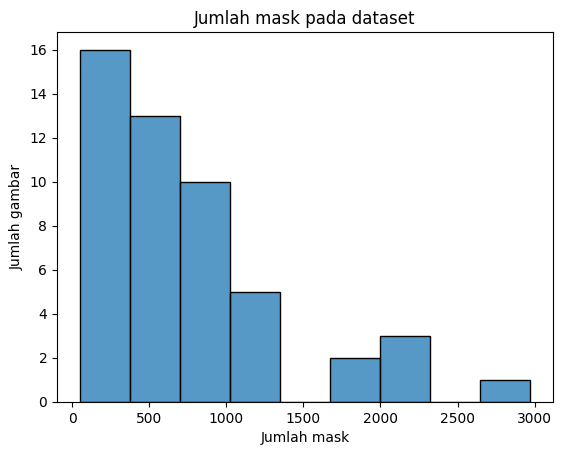

In [ ]:
# Visualisasi jumlah mask pada dataset
sns.histplot(df.groupby("file_name")["segmentation"].count())
plt.title("Jumlah mask pada dataset")
plt.xlabel("Jumlah mask")
plt.ylabel("Jumlah gambar")
plt.show()

# Visualisasi

In [14]:
# Fungsi untuk normalisasi gambar
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)

In [19]:
# Mendefinisikan file tiff yang akan dibuka
file_name = "train_4.tif"
dummy = df[df["file_name"] == file_name].reset_index(drop = True)
image_dir = "/content/drive/MyDrive/Solafune/images/" + file_name

In [20]:
# Membuka image pada image_dir
with rasterio.open(image_dir) as src:
  tiff_image = src.read()
  metadata = src.meta
  print(metadata)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1199, 'height': 802, 'count': 12, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 33.76964782367788,
       0.0, -8.983152841195215e-05, 48.23432052857041)}


In [21]:
# Ambil rgb image
r = normalize(tiff_image[4])
g = normalize(tiff_image[3])
b = normalize(tiff_image[2])
rgb_image = np.dstack([r, g, b])

In [22]:
# Mengambil height and width
_, height, width = tiff_image.shape

In [23]:
# Menggabungkan seluruh mask
combined_mask = np.zeros((height, width))
for i in range(dummy.shape[0]):
  segmentation = dummy["segmentation"][i]
  mask = np.zeros((height, width))
  segmentation_array = np.array([[x, y] for x, y in zip(segmentation[::2], segmentation[1::2])], dtype = np.int32)
  mask = cv2.fillPoly(mask, [segmentation_array], color = 1)
  combined_mask = np.maximum(combined_mask, mask)

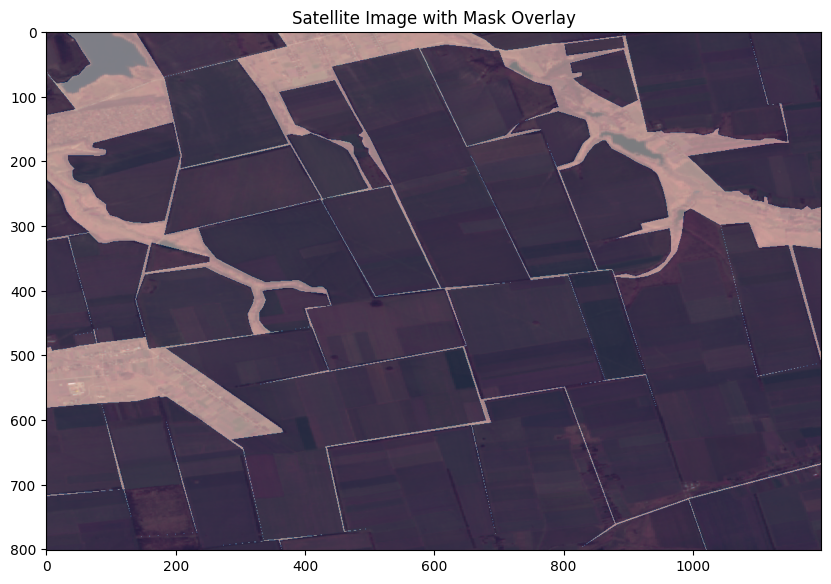

In [26]:
# Plot the image and mask
plt.figure(figsize = (10, 10))
plt.imshow(rgb_image, cmap = 'gray')
plt.title('Satellite Image with Mask Overlay')
plt.imshow(combined_mask, cmap = 'Blues', alpha = 0.5)
plt.show()

In [ ]:
# Menyimpan binary mask
cv2.imwrite("train_4_mask.tif", combined_mask * 255)

# Preprocessing

In [8]:
# Beberapa helper functions berguna

# Fungsi untuk normalisasi gambar
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)

# Fungsi untuk membuat tensorflow dataset
def create_dataset(df, input_shape):
  images = []
  masks = []
  edges = []
  for file_name in os.listdir("images"):
    # Mendapatkan copy dataframe
    df = df.copy()

    # Mendefinisikan file tiff yang akan dibuka
    dummy = df[df["file_name"] == file_name].reset_index(drop = True)
    image_dir = "/content/drive/MyDrive/Solafune/images/" + file_name

    # Memilih band yang akan digunakan (ambil band dengan resolusi sama)
    # Disini kita akan menggunakan resolusi 10 m yaitu B2, B3, B4, B8
    bands = [2, 3, 4, 8]

    # Membuka image pada image_dir dan mengambil band sesuai
    with rasterio.open(image_dir) as src:
      b = normalize(src.read(2))
      g = normalize(src.read(3))
      r = normalize(src.read(4))
      nir = normalize(src.read(8))

    # Menggabungkan atau stack semua image
    tiff_image = np.stack([r, g, b, nir], axis = -1)

    # Mengambil height and width
    height, width, _ = tiff_image.shape

    # Melakukan resize image ke input_shape supaya compatible dengan U-Net
    tiff_image = cv2.resize(tiff_image, input_shape, interpolation = cv2.INTER_LINEAR)

    # Menggabungkan seluruh mask
    combined_mask = np.zeros((height, width))
    for i in range(dummy.shape[0]):
      segmentation = dummy["segmentation"][i]
      mask = np.zeros((height, width))
      segmentation_array = np.array([[x, y] for x, y in zip(segmentation[::2], segmentation[1::2])], dtype = np.int32)
      mask = cv2.fillPoly(mask, [segmentation_array], color = 1)
      combined_mask = cv2.bitwise_or(combined_mask, mask)

    # Melakukan resize mask ke input_shape supaya compatible dengan U-Net
    combined_mask = cv2.resize(combined_mask, input_shape, interpolation = cv2.INTER_NEAREST)

    # Membuat edge mask menggunakan skimage
    edge_mask = filters.sobel(combined_mask)

    # Melakukan append ke list images dan masks
    images.append(tiff_image)
    masks.append(combined_mask)
    edges.append(edge_mask)

  # Mengkonversi images dan masks ke numpy array
  images = np.array(images)
  masks = np.array(masks)
  edges = np.array(edges)

  return images, edges, masks

# Fungsi untuk menyimpan images dan masks
def save_images_and_masks(images, masks, images_dir, masks_dir):
  for i in range(len(images)):
    # Menavigasi ke train dir dan save
    os.chdir(images_dir)
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    cv2.imwrite("train_" + str(i) + ".tif", image)
    os.chdir("..")
    # Menavigasi ke mask dir dan save
    os.chdir(masks_dir)
    cv2.imwrite("train_" + str(i) + "_" + "mask" + ".tif", masks[i] * 255)
    os.chdir("..")

  return print("Berhasil menyimpan images dan masks!")

# Fungsi untuk visualisasi images dan masks
def display(display_list):
  plt.figure(figsize = (15, 15))

  title = ['Input Image', 'True Mask', 'Edge Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [9]:
# Mendapatkan dataset berupa images and masks
images, edges, masks = create_dataset(df, (1024, 1024))

<ipython-input-8-70ed7a991707>:6: RuntimeWarning: invalid value encountered in cast
  return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)


In [10]:
# Menghilangkan images defect
images = np.delete(images, [30, 35], axis = 0)
edges = np.delete(edges, [30, 35], axis = 0)
masks = np.delete(masks, [30, 35], axis = 0)

In [ ]:
# Menyimpan dataset ke direktori yang ditentukan
save_images_and_masks(images, masks, "train", "label")

Berhasil menyimpan images dan masks!


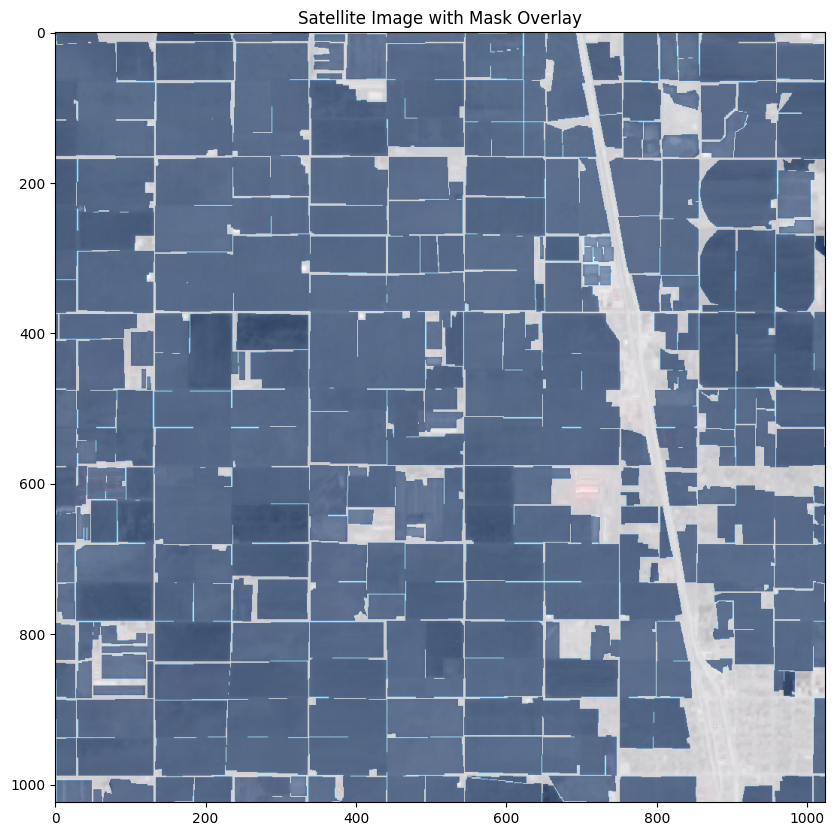

In [ ]:
# Plot the image and mask
plt.figure(figsize = (10, 10))
plt.imshow(images[40], cmap = 'gray')
plt.title('Satellite Image with Mask Overlay')
plt.imshow(masks[40], cmap = 'Blues', alpha = 0.5)
plt.show()

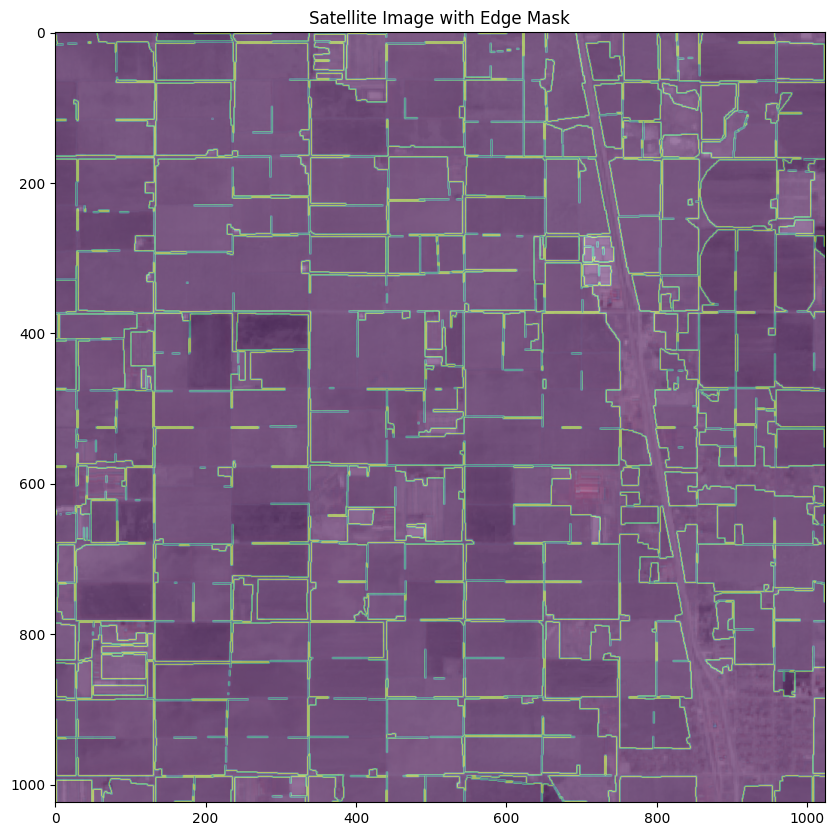

In [ ]:
# Plot the image and edge mask
plt.figure(figsize = (10, 10))
plt.imshow(images[40])
plt.title('Satellite Image with Edge Mask')
plt.imshow(edges[40], alpha = 0.5)
plt.show()

In [11]:
# Membuat tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, edges, masks))

In [12]:
# Melakukan normalisasi ke [0, 1] dan batching
def normalize(image, edge, mask):
    image = tf.cast(image, tf.float32) / 255.0
    edge = tf.cast(edge, tf.float32)
    mask = tf.cast(mask, tf.int32)
    return image, edge, mask

dataset = dataset.map(normalize)
dataset = dataset.shuffle(buffer_size = 10)

In [13]:
# Melakukan splitting ke training dan validation set
train_size = int(0.8 * len(images))
val_size = len(images) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_batch_size = 8
val_batch_size = 2

train_dataset = train_dataset.batch(train_batch_size)
val_dataset = val_dataset.batch(val_batch_size)

train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
# Fungsi untuk melakukan penyesuaian input model
def process_sample(image, edge_mask, ground_truth_mask):
  return (image, edge_mask), ground_truth_mask

train_dataset = train_dataset.map(process_sample)
val_dataset = val_dataset.map(process_sample)

In [ ]:
# Visualisasi tensorflow dataset
for images, masks, edges in train_dataset.take(2):
  sample_image, sample_mask, sample_edge = images[0], masks[0], edges[0]
  sample_mask = tf.expand_dims(sample_mask, axis = -1)
  sample_edge = tf.expand_dims(sample_edge, axis = -1)
  display([sample_image, sample_mask, sample_edge])

# Modelling

In [16]:
# Beberapa helper functions berguna

# Fungsi untuk U-Net
def unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = layers.Activation('relu')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(conv5)
    conv5 = layers.Activation('relu')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = layers.Activation('relu')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = layers.Activation('relu')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = layers.Activation('relu')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    conv9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = layers.Activation('relu')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Fungsi untuk Dual U-Net
def dual_unet(input_shape_sentinel, input_shape_edge):
    # First branch: Input untuk 12-channel Sentinel-2 data
    sentinel_input = Input(shape=input_shape_sentinel, name='sentinel_input')

    # Second branch: Input untuk 1-channel edge mask
    edge_input = Input(shape=input_shape_edge, name='edge_input')

    # U-Net encoder untuk Sentinel-2 input
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(sentinel_input)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # U-Net encoder untuk Edge Mask input
    c1_edge = Conv2D(64, (3, 3), activation='relu', padding='same')(edge_input)
    c1_edge = Conv2D(64, (3, 3), activation='relu', padding='same')(c1_edge)
    p1_edge = layers.MaxPooling2D((2, 2))(c1_edge)

    c2_edge = Conv2D(128, (3, 3), activation='relu', padding='same')(p1_edge)
    c2_edge = Conv2D(128, (3, 3), activation='relu', padding='same')(c2_edge)
    p2_edge = layers.MaxPooling2D((2, 2))(c2_edge)

    # Concatenate kedua branches at some point
    merged = layers.concatenate([p2, p2_edge])

    # U-Net decoding path (upsampling)
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(merged)
    u1 = layers.concatenate([u1, c2])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    # Final output layer dengan 1 channel (binary classification: field vs non-field)
    output = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    # Define the model dengan two inputs
    model = tf.keras.Model(inputs=[sentinel_input, edge_input], outputs=[output])

    return model

# Fungsi untuk Dice Loss
def dice_loss(y_true, y_pred, smooth = 1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Fungsi untuk Combined Loss
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Fungsi untuk metrik dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32) # Cast y_true_f to float32
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Fungsi untuk metrik iou
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32) # Cast y_true_f to float32
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection + smooth)

In [22]:
# Mendefinisikan model Dual U-Net
input_shape = (1024, 1024, 4)
input_shape_edge = (1024, 1024, 1)
model = dual_unet(input_shape, input_shape_edge)

In [23]:
# Melihat model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sentinel_input            │ (None, 1024, 1024, 4)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ edge_input (InputLayer)   │ (None, 1024, 1024, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 1024, 1024, 64) │          2,368 │ sentinel_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 1024, 1024, 64) │            640 │ edge_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 1024, 1024, 64) │         36,928 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 1024, 1024, 64) │         36,928 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 512, 512, 64)   │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 512, 512, 64)   │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 512, 512, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 512, 512, 128)  │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 512, 512, 128)  │        147,584 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 512, 512, 128)  │        147,584 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 256, 256, 128)  │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 256, 256, 128)  │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 256, 256, 256)  │              0 │ max_pooling2d_5[0][0], │
│ (Concatenate)             │                        │                │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 512, 512, 128)  │        131,200 │ concatenate_3[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├──────────────────────

 Total params: 1,237,185 (4.72 MB)

 Trainable params: 1,237,185 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Melakukan compile model
model.compile(optimizer = "Adam", loss = combined_loss, metrics = [dice_coefficient, iou])

# Melakukan fitting model
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 200)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - dice_coefficient: 0.6061 - iou: 0.4373 - loss: 1.0687 - val_dice_coefficient: 0.8074 - val_iou: 0.6822 - val_loss: 0.9330
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 598ms/step - dice_coefficient: 0.7638 - iou: 0.6196 - loss: 0.9946 - val_dice_coefficient: 0.6804 - val_iou: 0.5173 - val_loss: 0.9296
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 599ms/step - dice_coefficient: 0.6956 - iou: 0.5347 - loss: 0.9083 - val_dice_coefficient: 0.7324 - val_iou: 0.5808 - val_loss: 0.8543
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 598ms/step - dice_coefficient: 0.7494 - iou: 0.6006 - loss: 0.8898 - val_dice_coefficient: 0.7582 - val_iou: 0.6120 - val_loss: 0.8917
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 599ms/step - dice_coefficient: 0.7600 - iou: 0.6130 - loss: 0.9236 - val_dice_coefficient: 0.7312 - val_iou: 0.5803 - val_loss: 0.8423
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 599ms/step - dice_coefficient: 0.7212 - iou: 0.5644 - loss: 0.8937 - val_dice_coefficie

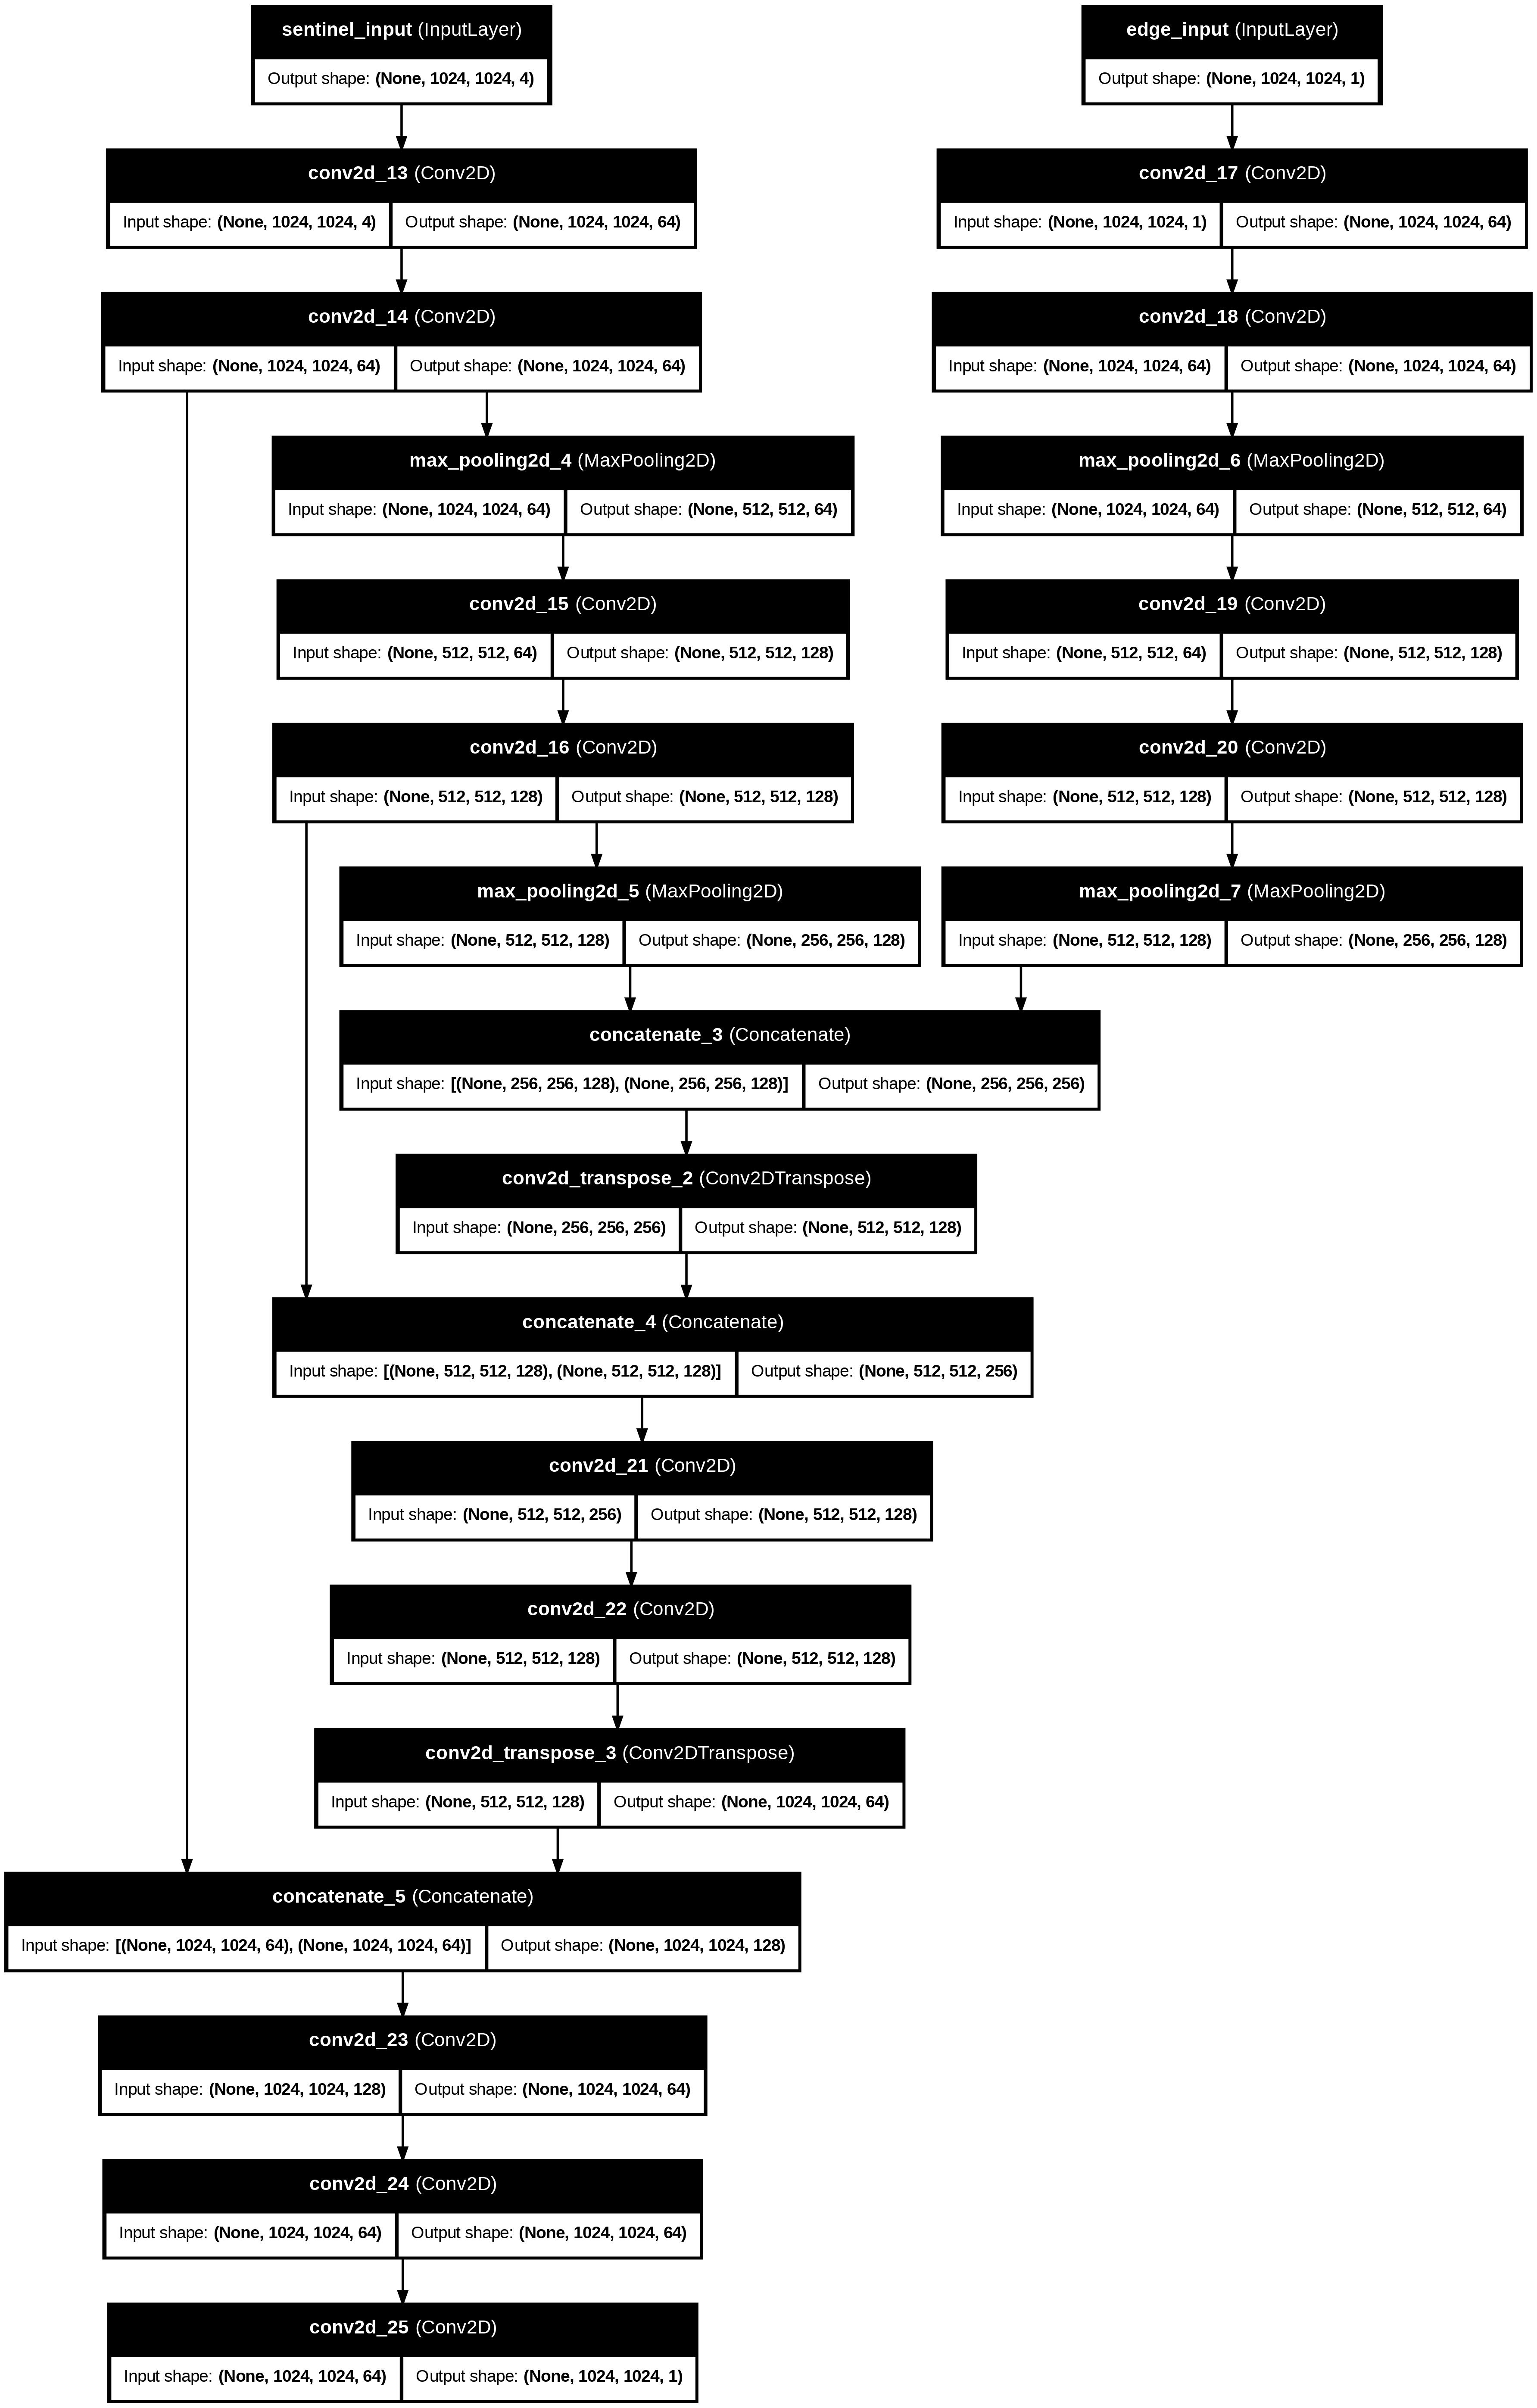

In [32]:
# Visualisasi arsitektur model
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Menyimpan weights model
model.save("best_weights.h5")

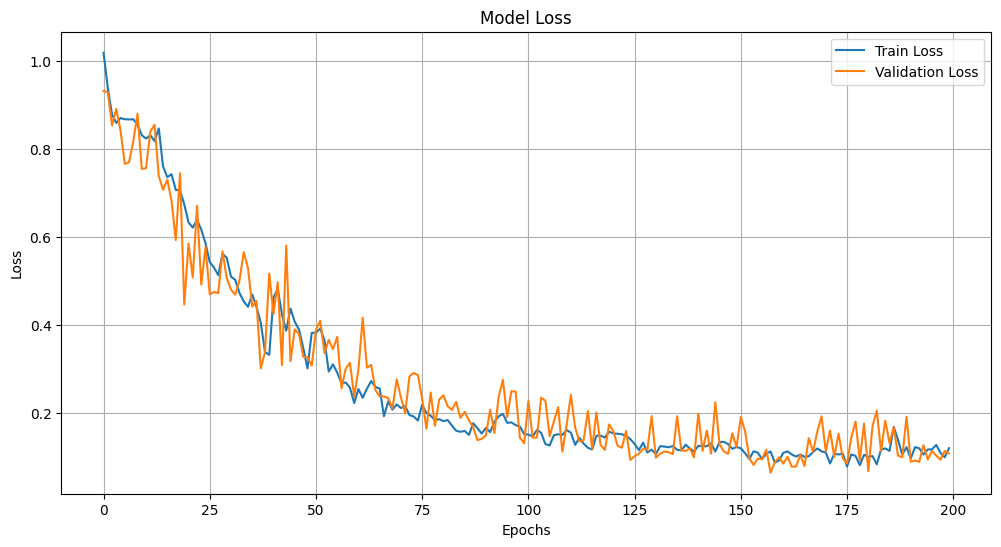

In [26]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plot
plt.show()

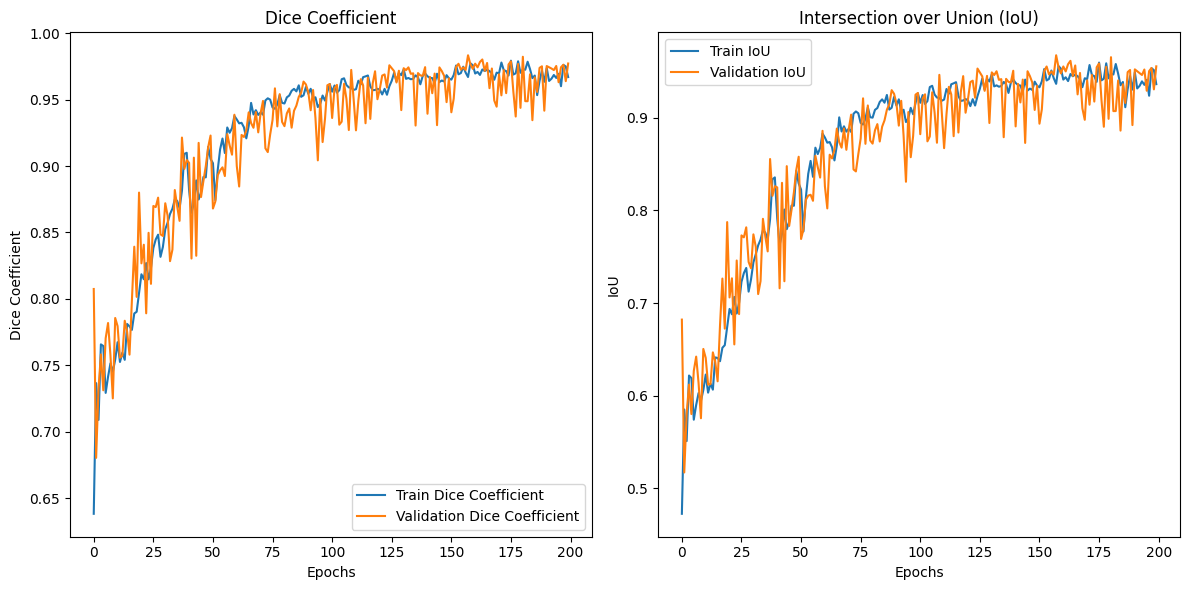

In [27]:
# Plotting Dice Coefficient
plt.figure(figsize=(12, 6))

# Plot Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.title('Intersection over Union (IoU)')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# Beberapa fungsi untuk membantu dan visualisasi prediksi

def display(display_list):
  plt.figure(figsize = (15, 15))

  title = ['Input Image', 'Edge Mask', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  threshold = 0.5
  binary_mask = (pred_mask > threshold)
  return binary_mask[0]

def show_predictions(dataset = None, num = 1):
  if dataset:
    for X, mask in dataset.take(num):
      pred_mask = model.predict(X)
      image = X[0]
      edge = X[1]
      mask = tf.expand_dims(mask, axis = -1)
      edge = tf.expand_dims(edge, axis = -1)
      display([image[0], edge[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


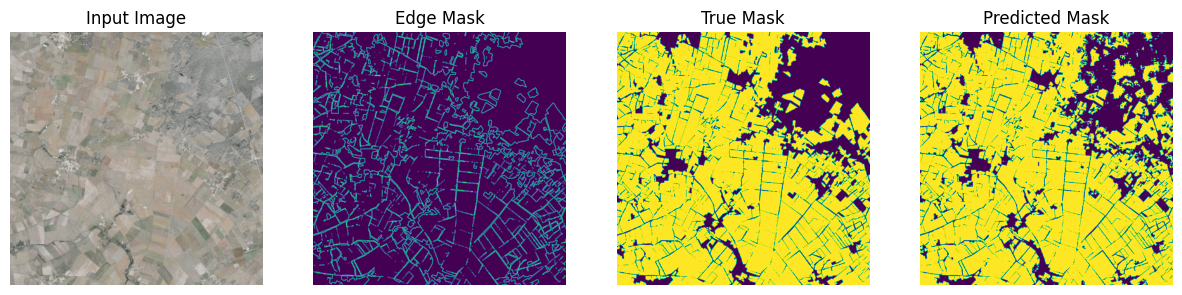

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


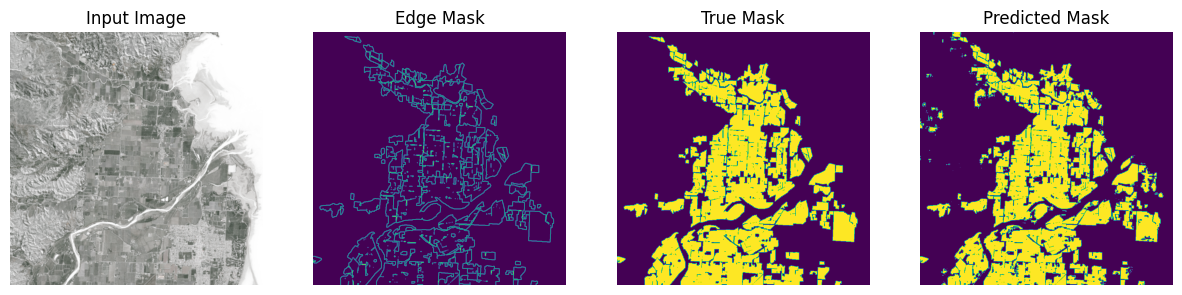

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


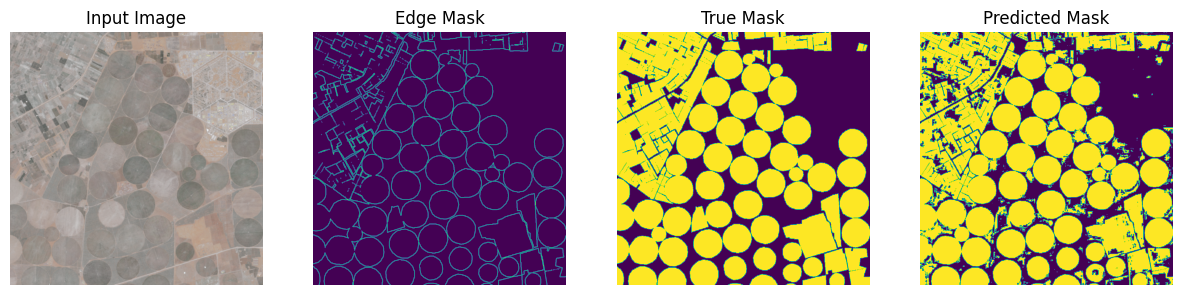

In [29]:
show_predictions(val_dataset, 3)